In [0]:
from IPython.display import clear_output

In [0]:
!pip3 install pycodestyle flake8 pycodestyle_magic
clear_output()

In [0]:
%load_ext pycodestyle_magic

# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [5]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

In [0]:
from scipy.special import expit
# функцию сигмоиды взяла из scipy,
# потому что обычная при некоторых значениях
# выдаёт ошибку "overflow encountered in exp",
# на корректность решения это не влияет

auc 0.9966315042992642


Text(0, 0.5, 'train loss')

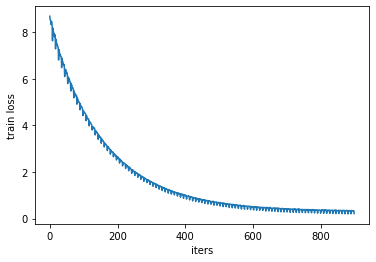

In [20]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size

    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0

        for epoch in range(self.n_epochs):

            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))

            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]

                # forward pass
                # <TODO> [1 point] calculate batch loss
                h1 = batch_X @ self.w + self.b
                loss = -np.sum(batch_y * np.log(expit(h1)) +
                               (1 - batch_y) * np.log(1 - expit(h1))
                               ) / self.batch_size + (
                                   self.llambda / 2) * (self.w.T @ self.w)

                # backward pass
                # <TODO> [2 points] calculate batch gradients
                loss_delta = expit(h1) - batch_y
                grad_w = (batch_X.T @ loss_delta.T
                          ) / self.batch_size + self.llambda * self.w
                grad_b = np.sum(loss_delta) / self.batch_size

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b

                self.history.append(loss)

        return self

    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        h1 = X @ self.w + self.b
        p = expit(h1)
        return p

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)


model = LogRegNumpy(llambda=0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin,
                                   model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss')

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):

    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()

        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1)
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        self.linear = nn.Linear(in_features=n_features, out_features=n_classes)

    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model
        result = F.log_softmax(self.linear(x), dim=1)
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
def train(model, train_loader, valid_loader,
          n_epochs, early_stopping_patience=5):
    """
    early_stopping_patience - number of consecutive epochs
    of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    counter = 0
    best_score = None
    for epoch in range(n_epochs):
        epoch_train_loss = 0

        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader,
                                     desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)

        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss

        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f}' +
              f'valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)

        # <TODO> implement early stopping using early_stopping_patience
        if best_score is None:
            best_score = epoch_valid_loss
        if epoch_valid_loss > best_score:
            best_score = epoch_valid_loss
            counter += 1
            if counter > early_stopping_patience:
                break
    return history

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):

    model.eval()

    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = np.argmax(torch.exp(model(batch_x)) /
                             torch.exp(model(batch_x)).sum(), axis=1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [35]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)


train loss: 2.817valid loss:2.634



train loss: 2.443valid loss:2.333



train loss: 2.134valid loss:2.100



train loss: 1.891valid loss:1.888



train loss: 1.697valid loss:1.738



train loss: 1.544valid loss:1.635



train loss: 1.427valid loss:1.519



train loss: 1.327valid loss:1.453



train loss: 1.247valid loss:1.374



train loss: 1.178valid loss:1.322



train loss: 1.121valid loss:1.280



train loss: 1.073valid loss:1.239



train loss: 1.030valid loss:1.201



train loss: 0.995valid loss:1.176



train loss: 0.965valid loss:1.151



train loss: 0.937valid loss:1.131



train loss: 0.911valid loss:1.117



train loss: 0.889valid loss:1.092



train loss: 0.872valid loss:1.083



train loss: 0.857valid loss:1.068



train loss: 0.841valid loss:1.058



train loss: 0.829valid loss:1.044



train loss: 0.816valid loss:1.038



train loss: 0.805valid loss:1.027



train loss: 0.795valid loss:1.022



train loss: 0.786valid loss:1.022



train loss: 0.779valid loss:1.011



train loss: 0.768valid loss:1.001



train loss: 0.763valid loss:1.002



train loss: 0.757valid loss:0.994



train loss: 0.750valid loss:0.996



train loss: 0.747valid loss:0.990



train loss: 0.740valid loss:0.983



train loss: 0.736valid loss:0.980



train loss: 0.731valid loss:0.975



train loss: 0.728valid loss:0.975



train loss: 0.724valid loss:0.978



train loss: 0.722valid loss:0.976



train loss: 0.718valid loss:0.965



train loss: 0.714valid loss:0.964



train loss: 0.710valid loss:0.961



train loss: 0.709valid loss:0.964



train loss: 0.708valid loss:0.962



train loss: 0.707valid loss:0.963



train loss: 0.704valid loss:0.961



train loss: 0.702valid loss:0.963



train loss: 0.701valid loss:0.956



train loss: 0.700valid loss:0.958



train loss: 0.698valid loss:0.962



train loss: 0.696valid loss:0.958



train loss: 0.693valid loss:0.954



train loss: 0.695valid loss:0.958



train loss: 0.693valid loss:0.957



train loss: 0.692valid loss:0.956



train loss: 0.692valid loss:0.957



train loss: 0.690valid loss:0.951



train loss: 0.688valid loss:0.953



train loss: 0.688valid loss:0.954



train loss: 0.685valid loss:0.948



train loss: 0.685valid loss:0.953



train loss: 0.685valid loss:0.951



train loss: 0.685valid loss:0.949



train loss: 0.684valid loss:0.948



train loss: 0.684valid loss:0.952



train loss: 0.683valid loss:0.953



train loss: 0.683valid loss:0.948



train loss: 0.685valid loss:0.949



train loss: 0.684valid loss:0.953



train loss: 0.681valid loss:0.946



train loss: 0.681valid loss:0.947



train loss: 0.679valid loss:0.952



train loss: 0.680valid loss:0.946



train loss: 0.680valid loss:0.946



train loss: 0.680valid loss:0.947



train loss: 0.681valid loss:0.948



train loss: 0.679valid loss:0.947



train loss: 0.679valid loss:0.947



train loss: 0.677valid loss:0.949



train loss: 0.679valid loss:0.947



train loss: 0.677valid loss:0.945



train loss: 0.678valid loss:0.949



train loss: 0.677valid loss:0.947



train loss: 0.676valid loss:0.952



train loss: 0.676valid loss:0.946



train loss: 0.677valid loss:0.947



train loss: 0.678valid loss:0.950



train loss: 0.675valid loss:0.944



train loss: 0.675valid loss:0.944



train loss: 0.675valid loss:0.946



train loss: 0.677valid loss:0.945



train loss: 0.675valid loss:0.947



train loss: 0.676valid loss:0.945



train loss: 0.674valid loss:0.943



train loss: 0.676valid loss:0.950



train loss: 0.675valid loss:0.946



train loss: 0.674valid loss:0.947



train loss: 0.675valid loss:0.942



train loss: 0.674valid loss:0.944



train loss: 0.677valid loss:0.947



train loss: 0.675valid loss:0.948


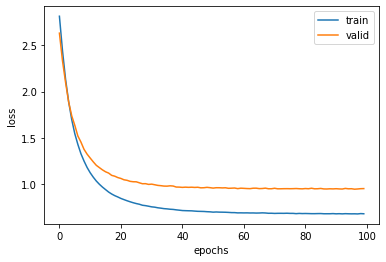

In [36]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [45]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.8106744556558683

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [0]:
from sklearn.dummy import DummyClassifier

In [61]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
metrics.log_loss(y_test, y_pred)

2.9957322735539913

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [63]:
metrics.accuracy_score(y_test, [1 for i in range(len(y_test))])

0.05164630908125332